In [1]:
'''
Installing packages for rendering the game on Colab
'''

!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1
!pip install git+https://github.com/tensorflow/docs > /dev/null 2>&1
!pip install gym[classic_control]

**imports**

In [2]:
'''
A bunch of imports, you don't have to worry about these
'''

import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import namedtuple, deque
import torch.optim as optim
import datetime
import gym
from gym.wrappers.record_video import RecordVideo
import glob
import io
import base64
import matplotlib.pyplot as plt
from IPython.display import HTML
from pyvirtualdisplay import Display
import tensorflow as tf
from IPython import display as ipythondisplay
from PIL import Image
import tensorflow_probability as tfp

/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/__init__.py:57: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if (distutils.version.LooseVersion(tf.__version__) <


***DQN's of both types***

In [3]:
'''
### Q Network & Some 'hyperparameters'

QNetwork1:
Input Layer - 4 nodes (State Shape) \
Hidden Layer 1 - 128 nodes \
Hidden Layer 2 - 64 nodes \
Output Layer - 2 nodes (Action Space) \
Optimizer - zero_grad()
'''

import torch
import torch.nn as nn
import torch.nn.functional as F


'''
Bunch of Hyper parameters (Which you might have to tune later)
'''
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
LR = 1e-3               # learning rate
UPDATE_EVERY = 20       # how often to update the network (When Q target is present)


class QNetwork1(nn.Module):

    def __init__(self, state_size, action_size, seed, fc1_units=128, fc2_units=64):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(QNetwork1, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.A_O = nn.Linear(fc2_units, action_size)
        self.V_O = nn.Linear(fc2_units, 1)

    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))

        V = self.V_O(x)
        A = self.A_O(x)

        Q = V + (A - torch.mean(A, dim=1, keepdim=True))
        return Q


class QNetwork2(nn.Module):

    def __init__(self, state_size, action_size, seed, fc1_units=128, fc2_units=64):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(QNetwork2, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.A_O = nn.Linear(fc2_units, action_size)
        self.V_O = nn.Linear(fc2_units, 1)

    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))

        V = self.V_O(x)
        A = self.A_O(x)

        Q = V + (A - torch.max(A, dim=1, keepdim=True)[0])
        return Q


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
import random
import torch
import numpy as np
from collections import deque, namedtuple

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [5]:
class Agent():

    def __init__(self, QNetwork, state_size, action_size, seed):

        ''' Agent Environment Interaction '''
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        ''' Q-Network '''
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        ''' Replay memory '''
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)

        ''' Initialize time step (for updating every UPDATE_EVERY steps)           -Needed for Q Targets '''
        self.t_step = 0

    def step(self, state, action, reward, next_state, done):

        ''' Save experience in replay memory '''
        self.memory.add(state, action, reward, next_state, done)

        ''' If enough samples are available in memory, get random subset and learn '''
        if len(self.memory) >= BATCH_SIZE:
            experiences = self.memory.sample()
            self.learn(experiences, GAMMA)

        """ +Q TARGETS PRESENT """
        ''' Updating the Network every 'UPDATE_EVERY' steps taken '''
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:

            self.qnetwork_target.load_state_dict(self.qnetwork_local.state_dict())

    def act(self, state, tau=1):

        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        tensor_input=torch.tensor(action_values.cpu().data.numpy())/tau
        probabilities = F.softmax(tensor_input, dim=1).numpy()[0]

        return np.random.choice(np.arange(self.action_size),p=probabilities)

    def learn(self, experiences, gamma):
        """ +E EXPERIENCE REPLAY PRESENT """
        states, actions, rewards, next_states, dones = experiences

        ''' Get max predicted Q values (for next states) from target model'''
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)

        ''' Compute Q targets for current states '''
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        ''' Get expected Q values from local model '''
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        ''' Compute loss '''
        loss = F.mse_loss(Q_expected, Q_targets)

        ''' Minimize the loss '''
        self.optimizer.zero_grad()
        loss.backward()

        ''' Gradiant Clipping '''
        """ +T TRUNCATION PRESENT """
        for param in self.qnetwork_local.parameters():
            param.grad.data.clamp_(-1, 1)

        self.optimizer.step()

***Dueling DQN***

In [6]:
''' Defining DQN Algorithm '''


def dueling_dqn(env, agent, reward_threshold, seed, tau=1, n_episodes=10000, max_t=1000):

    rewards=np.zeros(n_episodes)

    scores_window = deque(maxlen=100)

    for i_episode in range(n_episodes):

        state = env.reset(seed=seed)
        score = 0
        for t in range(max_t):
            action = agent.act(state, tau)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break
        rewards[i_episode]+=score

        scores_window.append(score)

        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")

        if i_episode % 100 == 0:
          print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=reward_threshold:
          print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
          return rewards,i_episode
    print('\nEnvironment didn\'t solved and ended of timesteps constraint at {:d} episodes! with \t Average Score: {:.2f}'.format(n_episodes, np.mean(scores_window)))
    return rewards,n_episodes


***acrobot***

In [19]:
acrobot = gym.make('Acrobot-v1')

state_size = acrobot.observation_space.shape[0]
action_size = acrobot.action_space.n

n_episodes=500
seeds=[7,49,128,2035,12345]

rewards1=np.zeros((len(seeds),n_episodes))
rewards2=np.zeros((len(seeds),n_episodes))

for ind in range(len(seeds)):
      seed = seeds[ind]
      rewards1[ind],timesteps=dueling_dqn(acrobot,Agent(QNetwork1, state_size, action_size, seed=seed),reward_threshold=-100,seed=seed,tau=0.5,n_episodes=n_episodes)
      for i in range(timesteps+1,n_episodes):
        rewards1[ind][i]=rewards1[ind][i-1]

      rewards2[ind],timesteps=dueling_dqn(acrobot,Agent(QNetwork2, state_size, action_size, seed=seed),reward_threshold=-100,seed=seed,tau=0.5,n_episodes=n_episodes)
      for i in range(timesteps+1,n_episodes):
        rewards2[ind][i]=rewards2[ind][i-1]


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 0	Average Score: -500.00
Episode 100	Average Score: -138.59
Episode 200	Average Score: -122.76
Episode 300	Average Score: -118.44
Episode 400	Average Score: -118.68
Episode 499	Average Score: -118.05
Environment didn't solved and ended of timesteps constraint at 500 episodes! with 	 Average Score: -118.05
Episode 0	Average Score: -500.00
Episode 100	Average Score: -123.06
Episode 200	Average Score: -116.15
Episode 300	Average Score: -113.54
Episode 400	Average Score: -114.72
Episode 499	Average Score: -114.81
Environment didn't solved and ended of timesteps constraint at 500 episodes! with 	 Average Score: -114.81
Episode 0	Average Score: -500.00
Episode 100	Average Score: -129.78
Episode 200	Average Score: -119.91
Episode 300	Average Score: -119.25
Episode 400	Average Score: -115.28
Episode 499	Average Score: -116.84
Environment didn't solved and ended of timesteps constraint at 500 episodes! with 	 Average Score: -116.84
Episode 0	Average Score: -500.00
Episode 100	Average Sc

**ploting fuction**

In [17]:
def plot(mat1,mat2,ylabel='rewards',xlabel='Episode',episodes=1000):
    plt.figure(figsize=(6, 6))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    mean1=mat1.mean(axis=0)
    std1=mat1.std(axis=0)
    upper_bound1=mean1+std1
    lower_bound1=mean1-std1

    plt.plot(np.arange(0,episodes),mean1,color='midnightblue',label='type 1')
    plt.fill_between(np.arange(0,episodes), lower_bound1, upper_bound1, color='steelblue', alpha=0.2)

    mean2=mat2.mean(axis=0)
    std2=mat2.std(axis=0)
    upper_bound2=mean2+std2
    lower_bound2=mean2-std2

    plt.plot(np.arange(0,episodes),mean2,color='maroon',label='type 2')
    plt.fill_between(np.arange(0,episodes), lower_bound2, upper_bound2, color='lightcoral', alpha=0.2)
    plt.legend()
    plt.show()

**plots**

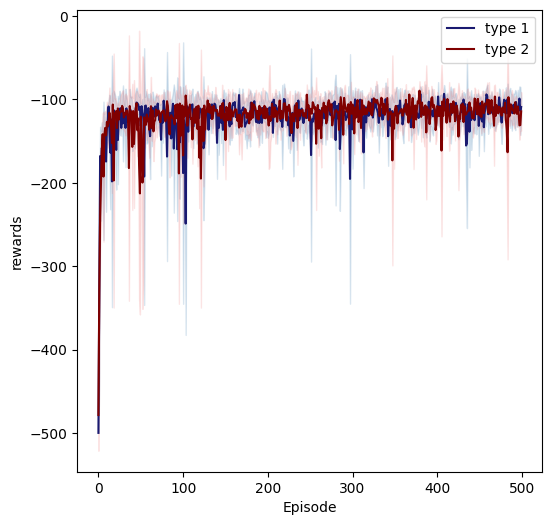

In [20]:
plot(rewards1,rewards2,episodes=n_episodes)

In [10]:
acrobot = gym.make('Acrobot-v1')

state_size = acrobot.observation_space.shape[0]
action_size = acrobot.action_space.n

n_episodes=500
seeds=[7,49,128,2035,12345]

rewards1=np.zeros((len(seeds),n_episodes))
rewards2=np.zeros((len(seeds),n_episodes))

for ind in range(len(seeds)):
      seed = seeds[ind]
      rewards1[ind],timesteps=dueling_dqn(acrobot,Agent(QNetwork1, state_size, action_size, seed=seed),reward_threshold=-100,seed=seed,tau=0.3,n_episodes=n_episodes)
      for i in range(timesteps+1,n_episodes):
        rewards1[ind][i]=rewards1[ind][i-1]

      rewards2[ind],timesteps=dueling_dqn(acrobot,Agent(QNetwork2, state_size, action_size, seed=seed),reward_threshold=-100,seed=seed,tau=0.3,n_episodes=n_episodes)
      for i in range(timesteps+1,n_episodes):
        rewards2[ind][i]=rewards2[ind][i-1]


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 0	Average Score: -500.00
Episode 100	Average Score: -107.84
Episode 158	Average Score: -99.06
Environment solved in 158 episodes!	Average Score: -99.06
Episode 0	Average Score: -500.00
Episode 100	Average Score: -112.67
Episode 200	Average Score: -108.85
Episode 290	Average Score: -99.68
Environment solved in 290 episodes!	Average Score: -99.68
Episode 0	Average Score: -500.00
Episode 100	Average Score: -113.67
Episode 200	Average Score: -116.62
Episode 300	Average Score: -110.47
Episode 400	Average Score: -105.91
Episode 499	Average Score: -102.16
Environment didn't solved and ended of timesteps constraint at 500 episodes! with 	 Average Score: -102.16
Episode 0	Average Score: -500.00
Episode 100	Average Score: -108.18
Episode 108	Average Score: -99.87
Environment solved in 108 episodes!	Average Score: -99.87
Episode 0	Average Score: -453.00
Episode 100	Average Score: -110.82
Episode 173	Average Score: -99.52
Environment solved in 173 episodes!	Average Score: -99.52
Episode 0	

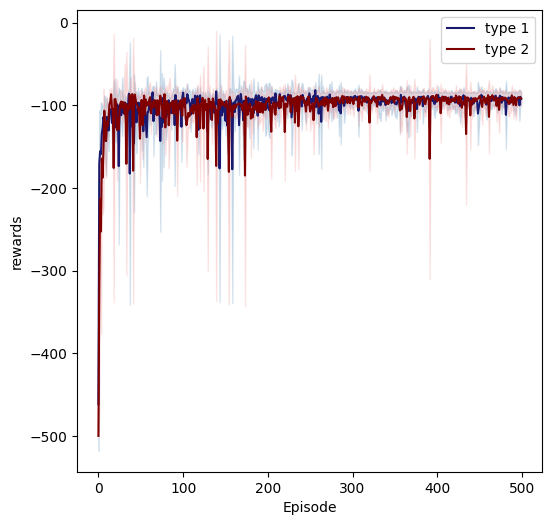

In [18]:
plot(rewards1,rewards2,episodes=n_episodes)